# ===============================================================
# TIME SERIES ANOMALY DETECTION - RELIANCE INDUSTRIES
# Author: Abhishek Shelke
# ===============================================================

# ================================
# 1. IMPORT LIBRARIES
# ================================

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from datetime import datetime


# ================================
# 2. DATA COLLECTION
# ================================

In [7]:
print("Downloading Reliance Industries data...")

ticker = "RELIANCE.NS"
start_date = "2019-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

df = yf.download(ticker, start=start_date, end=end_date)

# FIX MULTI-INDEX ISSUE
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.reset_index(inplace=True)

print("Data Downloaded Successfully!")
print(df.head())

/tmp/ipython-input-2834962075.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data Downloaded Successfully!
Price       Date       Close        High         Low        Open    Volume
0     2019-01-01  498.490570  501.292117  493.643536  500.380512   9746670
1     2019-01-02  491.998199  501.158692  489.596886  495.600125  15628818
2     2019-01-03  485.928314  495.644647  484.749906  492.487392  16288287
3     2019-01-04  488.551910  491.131092  480.747723  487.996071  18516544
4     2019-01-07  491.264496  497.356669  489.596920  492.265036  12060290


# ================================
# 3. DATA PREPROCESSING
# ================================



In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Daily Returns
df['Return'] = df['Close'].pct_change()

# Rolling Volatility (20-day)
df['Volatility'] = df['Return'].rolling(window=20).std()


df.dropna(inplace=True)


# ================================
# 4. EXPLORATORY DATA ANALYSIS
# ================================



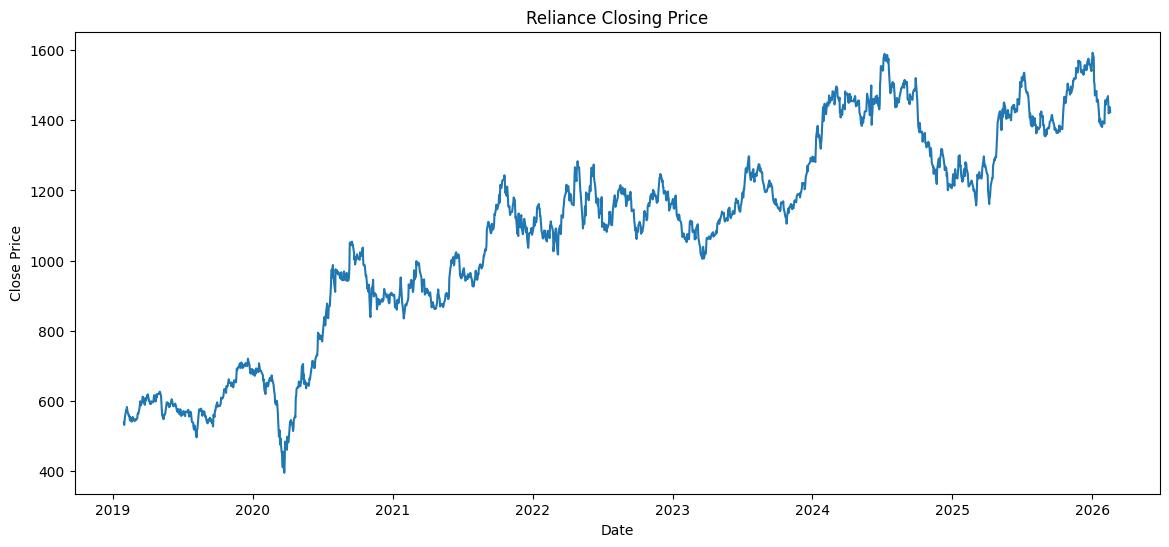

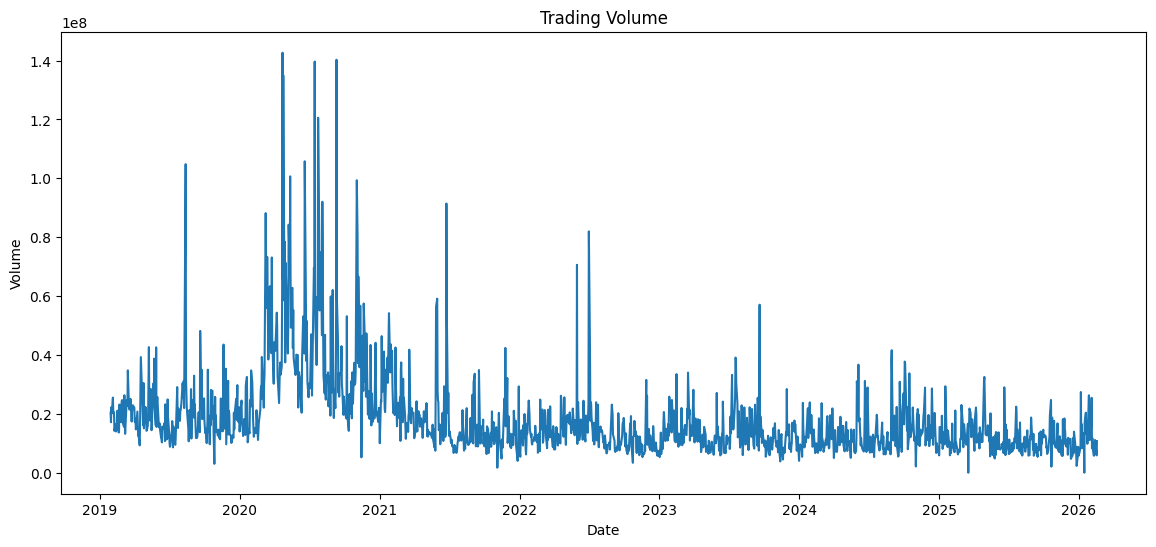

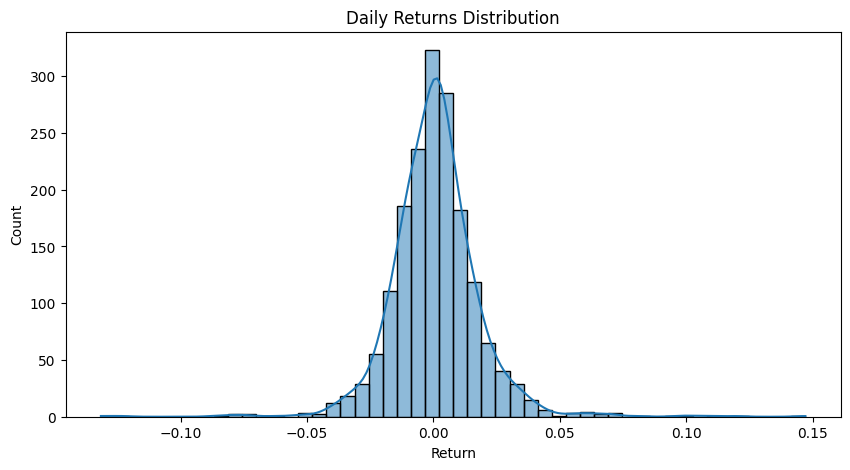

In [9]:
# Closing Price Plot
plt.figure(figsize=(14,6))
plt.plot(df['Close'])
plt.title("Reliance Closing Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# Volume Plot
plt.figure(figsize=(14,6))
plt.plot(df['Volume'])
plt.title("Trading Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

# Returns Distribution
plt.figure(figsize=(10,5))
sns.histplot(df['Return'], bins=50, kde=True)
plt.title("Daily Returns Distribution")
plt.show()



# ================================
# 5. STATISTICAL ANOMALY DETECTION
# ================================


In [10]:

# -------- Z-SCORE METHOD --------
df['Z_Score'] = (df['Return'] - df['Return'].mean()) / df['Return'].std()
df['Z_Anomaly'] = np.where(abs(df['Z_Score']) > 3, 1, 0)

print("Z-Score Anomalies:", df['Z_Anomaly'].sum())

# -------- IQR METHOD --------
Q1 = df['Return'].quantile(0.25)
Q3 = df['Return'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['IQR_Anomaly'] = np.where(
    (df['Return'] < lower_bound) | (df['Return'] > upper_bound),
    1, 0
)

print("IQR Anomalies:", df['IQR_Anomaly'].sum())

# -------- Moving Average Deviation --------
df['MA20'] = df['Close'].rolling(20).mean()
df['Deviation'] = df['Close'] - df['MA20']
df['MA_Anomaly'] = np.where(abs(df['Deviation']) > 2 * df['Deviation'].std(), 1, 0)

print("Moving Average Anomalies:", df['MA_Anomaly'].sum())


Z-Score Anomalies: 26
IQR Anomalies: 75
Moving Average Anomalies: 97


# ================================
# 6. MACHINE LEARNING METHODS
# ================================



In [11]:
features = df[['Return', 'Volume']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# -------- Isolation Forest --------
iso = IsolationForest(contamination=0.02, random_state=42)
df['IF_Anomaly'] = iso.fit_predict(scaled_features)
df['IF_Anomaly'] = df['IF_Anomaly'].map({1:0, -1:1})

print("Isolation Forest Anomalies:", df['IF_Anomaly'].sum())

# -------- One-Class SVM --------
svm = OneClassSVM(nu=0.02, kernel="rbf", gamma="auto")
df['SVM_Anomaly'] = svm.fit_predict(scaled_features)
df['SVM_Anomaly'] = df['SVM_Anomaly'].map({1:0, -1:1})

print("One-Class SVM Anomalies:", df['SVM_Anomaly'].sum())



Isolation Forest Anomalies: 35
One-Class SVM Anomalies: 41


# ================================
# 7. VISUALIZATION OF ANOMALIES
# ================================



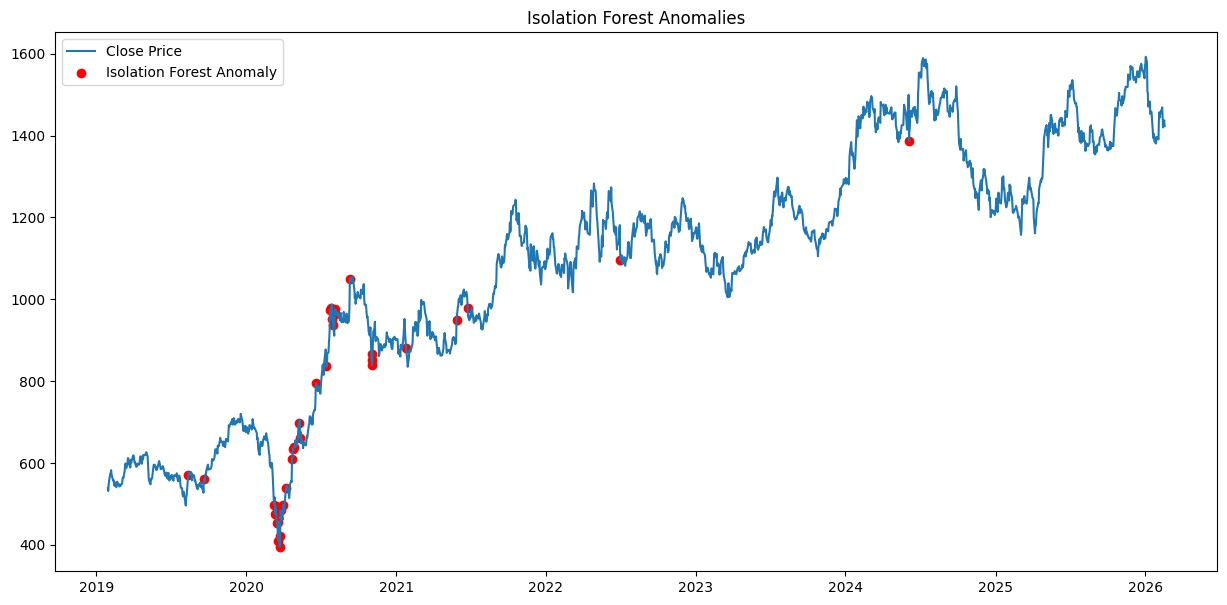

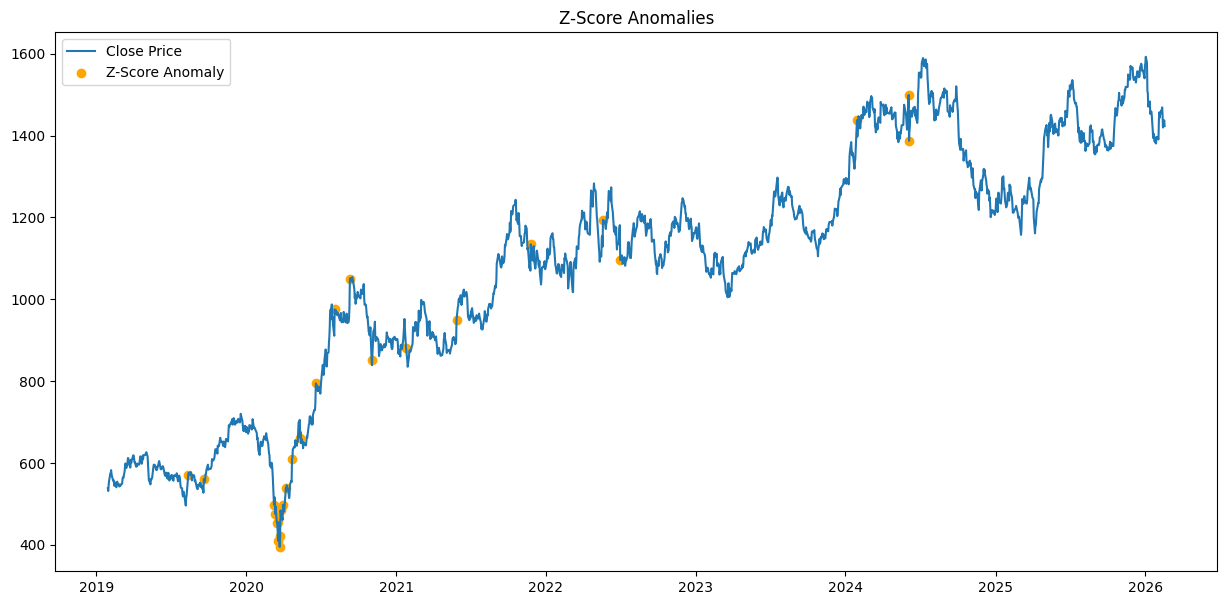

In [12]:
plt.figure(figsize=(15,7))
plt.plot(df['Close'], label="Close Price")
plt.scatter(df[df['IF_Anomaly']==1].index,
            df[df['IF_Anomaly']==1]['Close'],
            color='red', label="Isolation Forest Anomaly")
plt.title("Isolation Forest Anomalies")
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
plt.plot(df['Close'], label="Close Price")
plt.scatter(df[df['Z_Anomaly']==1].index,
            df[df['Z_Anomaly']==1]['Close'],
            color='orange', label="Z-Score Anomaly")
plt.title("Z-Score Anomalies")
plt.legend()
plt.show()



# ================================
# 8. EXTREME RETURN DAYS
# ================================



In [13]:
top_extreme = df.sort_values('Return', ascending=False).head(10)
print("\nTop 10 Positive Return Days")
print(top_extreme[['Return']])

bottom_extreme = df.sort_values('Return').head(10)
print("\nTop 10 Negative Return Days")
print(bottom_extreme[['Return']])




Top 10 Positive Return Days
Price         Return
Date                
2020-03-25  0.147180
2020-04-07  0.119402
2020-03-20  0.109240
2020-04-22  0.102033
2019-08-13  0.096937
2020-03-31  0.080839
2020-09-10  0.070627
2020-08-04  0.070483
2024-01-29  0.070192
2020-03-24  0.067134

Top 10 Negative Return Days
Price         Return
Date                
2020-03-23 -0.131539
2020-03-09 -0.123407
2020-11-02 -0.086177
2020-03-16 -0.081064
2020-03-12 -0.078497
2024-06-04 -0.074851
2022-07-01 -0.072025
2020-05-12 -0.061866
2021-01-25 -0.052986
2020-03-19 -0.052452


# ================================
# 9. CORRELATION ANALYSIS
# ================================



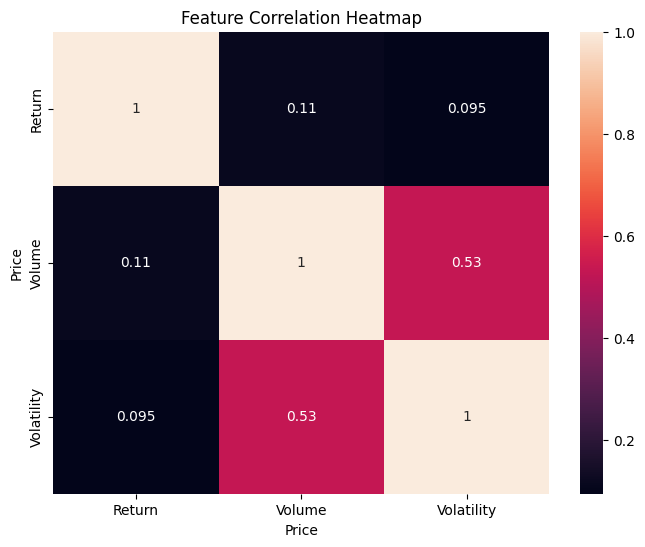

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Return','Volume','Volatility']].corr(), annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()



# ================================
# 10. SUMMARY REPORT
# ================================



In [15]:
print("\n========== FINAL SUMMARY ==========")
print("Total Observations:", len(df))
print("Z-Score Anomalies:", df['Z_Anomaly'].sum())
print("IQR Anomalies:", df['IQR_Anomaly'].sum())
print("Isolation Forest Anomalies:", df['IF_Anomaly'].sum())
print("SVM Anomalies:", df['SVM_Anomaly'].sum())
print("===================================")

print("\nProject Completed Successfully 🚀")


========== FINAL SUMMARY ==========
Total Observations: 1743
Z-Score Anomalies: 26
IQR Anomalies: 75
Isolation Forest Anomalies: 35
SVM Anomalies: 41

Project Completed Successfully 🚀
